# Analysis of lead times to produce batch products

Diego González Lozano

Firstly we import all the libraries needed and the data for the study:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

In [2]:
file = "Data tables for applicants_Randomized.xlsx"
sheet1 = "BOM"
sheet2 = "Material Movement"

bom = pd.read_excel(file, sheet_name=sheet1)
mat_mov = pd.read_excel(file, sheet_name=sheet2)

## Exploratory analysis and data preparation

Initially, we are going to start by analyzing the two datasets (visually and statistically) following with cleaning any possible errors or missing values.

### BOM:

In [3]:
print("\nFirst observations:")
bom.head(5)


First observations:


,PV Plant_R,PV Material Plant View_R,Material type,BI Component_R,Material type.1
0,BA01,F000134591,FERT,H000132846,HALB
1,BA01,F000137515,FERT,H000137029,HALB
2,AB01,F000013151,FERT,H000953195,HALB
3,AB01,F000019545,FERT,H000951723,HALB
4,AB01,F000015773,FERT,H000942704,HALB


To make the data easier to work with, the columns are going to be renamed:

In [4]:
bom.rename(columns={'PV Plant_R':'Plant', 
                    'PV Material Plant View_R':'Material', 
                    'Material type':'Material_type', 
                    'BI Component_R':'Component', 
                    'Material type.1':'Component_type'}, 
           inplace=True)

Next we are going to study the format of the columns and if there is any missing value:

In [5]:
print('General information')
print(bom.info())
print("------------------------------")
print()
print(bom.describe(include=['object']))
print()
print("------------------------------")
print()
print("Number of blanks or missings:")
print()
print(bom.isna().sum())
print()
print("------------------------------")
print('Number of duplicated rows:')
print(bom.duplicated().sum())

General information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Plant           502 non-null    object
 1   Material        502 non-null    object
 2   Material_type   502 non-null    object
 3   Component       502 non-null    object
 4   Component_type  502 non-null    object
dtypes: object(5)
memory usage: 19.7+ KB
None
------------------------------

       Plant    Material Material_type   Component Component_type
count    502         502           502         502            502
unique     4         480             2          72              1
top     AB01  H000133737          FERT  H000941991           HALB
freq     459           3           446          91            502

------------------------------

Number of blanks or missings:

Plant             0
Material          0
Material_type     0
Component         0
Component_type  

There are no missings in the sample and no duplicated rows. Furthermore only 4 different plant production sites, only 2 material types and one component type. The distribution of Plant and Material_type columns is now studied:

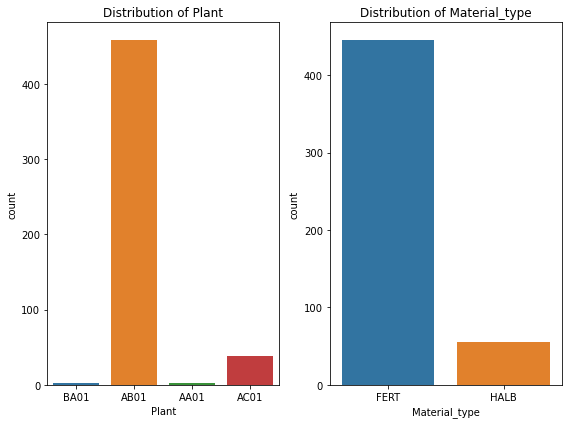

In [6]:
# Plant
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)  
sns.countplot(x='Plant', data=bom)
plt.title('Distribution of Plant')

# Material_type
plt.subplot(1, 2, 2)  
sns.countplot(x='Material_type', data=bom)
plt.title('Distribution of Material_type')

plt.tight_layout()
plt.show()

As seen in the table above, most of the products are made in AB01 and most of them are finished materials however 56 of them are components which can made by other components. Consequently we can convert the columns Plant, Material_type and Component_type into categorical values:

In [7]:
bom['Plant'] = bom['Plant'].astype('category')
bom['Material_type'] = bom['Material_type'].astype('category')
bom['Component_type'] = bom['Component_type'].astype('category')

Finally we are going to check if the other two columns which are IDs and will be used to join with the movement of materials table have any blank spaces which will lead to no joins.

In [8]:
def check_blank_spaces(data):
    for column in data.columns:
        if data[column].astype(str).str.contains('\s').any():
            print(f"Blank spaces found in the '{column}' column.")
        else:
            print(f"No blank spaces found in the '{column}' column.")
            
check_blank_spaces(bom)


No blank spaces found in the 'Plant' column.
Blank spaces found in the 'Material' column.
No blank spaces found in the 'Material_type' column.
Blank spaces found in the 'Component' column.
No blank spaces found in the 'Component_type' column.


As there are spaces we will remove them so that later on we don't lose any information.

In [9]:
bom['Material'] = bom['Material'].str.strip()
bom['Component'] = bom['Component'].str.strip()

#### Data Transformation 

We are going to study the cyclic dependecies where a component is produced by other components and produce a chain, 

In [10]:
chain = bom[bom['Material_type'] == 'FERT'].merge(
    bom[bom['Material_type'] == 'HALB'], 
    how='left', 
    left_on='Component', right_on='Material', 
    suffixes=('', '_2')
)

chain.drop(['Material_2', 'Material_type_2', 'Material_type', 'Component_type', 'Component_type_2'], axis=1, inplace=True)

print(chain.describe())
chain.head(5)


       Plant    Material   Component Plant_2 Component_2
count    463         463         463     450         450
unique     3         431          43       2          12
top     AB01  F000114936  H000941991    AB01  H000133737
freq     435           3          93     438         412


,Plant,Material,Component,Plant_2,Component_2
0,BA01,F000134591,H000132846,AB01,H000940217
1,BA01,F000137515,H000137029,NaN,NaN
2,AB01,F000013151,H000953195,AB01,H000133737
3,AB01,F000019545,H000951723,AB01,H000133737
4,AB01,F000015773,H000942704,AB01,H000133737


Here we can see that the 431 unique final materials are made from 43 unique components. This 43 components are made of 12 other unique components or are the primary product as seen in the second row from the table above. We are now going to study the supply chain further on:

In [11]:
chain2 = chain.merge(
    bom[bom['Material_type'] == 'HALB'], 
    how='left', 
    left_on='Component_2', right_on='Material', 
    suffixes=('', '_3')
)

chain2.drop(['Material_3', 'Material_type', 'Component_type'], axis=1, inplace=True)

print(chain2.describe())
chain2.head(5)

       Plant    Material   Component Plant_2 Component_2 Plant_3 Component_3
count   1287        1287        1287    1274        1274    1274        1274
unique     3         431          43       2          12       3           4
top     AB01  F000033537  H000941991    AB01  H000133737    AA01    H2SD9623
freq    1259           6         279    1262        1236    1236         412


,Plant,Material,Component,Plant_2,Component_2,Plant_3,Component_3
0,BA01,F000134591,H000132846,AB01,H000940217,AB01,H000133737
1,BA01,F000137515,H000137029,NaN,NaN,NaN,NaN
2,AB01,F000013151,H000953195,AB01,H000133737,AA01,H2SD9623
3,AB01,F000013151,H000953195,AB01,H000133737,AA01,H4LQ8330
4,AB01,F000013151,H000953195,AB01,H000133737,AA01,H5LQ6450


The 12 components in the second phase come from 4 other components or are the primary product. 

In [12]:
chain3 = chain2.merge(
    bom[bom['Material_type'] == 'HALB'], 
    how='left', 
    left_on='Component_3', right_on='Material', 
    suffixes=('', '_4')
)

chain3.drop(['Material_4', 'Material_type', 'Component_type'], axis=1, inplace=True)

print(chain3.describe())
chain3.head(5)

       Plant    Material   Component Plant_2 Component_2 Plant_3 Component_3  \
count   1363        1363        1363    1350        1350    1350        1350   
unique     3         431          43       2          12       3           4   
top     AB01  F000136500  H000941991    AB01  H000133737    AA01    H2SD9623   
freq    1297           6         279    1314        1236    1236         412   

       Plant_4 Component_4  
count      114         114  
unique       1           3  
top       AA01    H2SD9623  
freq       114          38  


,Plant,Material,Component,Plant_2,Component_2,Plant_3,Component_3,Plant_4,Component_4
0,BA01,F000134591,H000132846,AB01,H000940217,AB01,H000133737,AA01,H2SD9623
1,BA01,F000134591,H000132846,AB01,H000940217,AB01,H000133737,AA01,H4LQ8330
2,BA01,F000134591,H000132846,AB01,H000940217,AB01,H000133737,AA01,H5LQ6450
3,BA01,F000137515,H000137029,NaN,NaN,NaN,NaN,NaN,NaN
4,AB01,F000013151,H000953195,AB01,H000133737,AA01,H2SD9623,NaN,NaN


On the fourth stage of the chain there are only three products.

In [13]:
chain4 = chain3.merge(
    bom[bom['Material_type'] == 'HALB'], 
    how='left', 
    left_on='Component_4', right_on='Material', 
    suffixes=('', '_5')
)

chain4.drop(['Material_5', 'Material_type', 'Component_type'], axis=1, inplace=True)

print(chain4.describe())
chain4.head(5)

       Plant    Material   Component Plant_2 Component_2 Plant_3 Component_3  \
count   1363        1363        1363    1350        1350    1350        1350   
unique     3         431          43       2          12       3           4   
top     AB01  F000136500  H000941991    AB01  H000133737    AA01    H2SD9623   
freq    1297           6         279    1314        1236    1236         412   

       Plant_4 Component_4 Plant_5 Component_5  
count      114         114       0           0  
unique       1           3       0           0  
top       AA01    H2SD9623     NaN         NaN  
freq       114          38     NaN         NaN  


,Plant,Material,Component,Plant_2,Component_2,Plant_3,Component_3,Plant_4,Component_4,Plant_5,Component_5
0,BA01,F000134591,H000132846,AB01,H000940217,AB01,H000133737,AA01,H2SD9623,NaN,NaN
1,BA01,F000134591,H000132846,AB01,H000940217,AB01,H000133737,AA01,H4LQ8330,NaN,NaN
2,BA01,F000134591,H000132846,AB01,H000940217,AB01,H000133737,AA01,H5LQ6450,NaN,NaN
3,BA01,F000137515,H000137029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AB01,F000013151,H000953195,AB01,H000133737,AA01,H2SD9623,NaN,NaN,NaN,NaN


There is no further products on the supply chain. From this we can extract several conclusions:
1. There maximum number of components to make a product in the supply chain is 4. Which means there are 4 transformations before obtaining the final product. 
2. There are also chains of 3, 2 and only 1 component.

We are now going to divide them into the components needed and study the number of different products in each category.

In [14]:
chain3['Comp_category'] = np.where(chain3['Component_4'].notna(), '4', 
                                np.where(chain3['Component_3'].notna(), '3',
                                         np.where(chain3['Component_2'].notna(), '2',
                                                  '1')))


In [15]:
print(chain3.groupby('Comp_category')['Material'].nunique())

Comp_category
1     12
3    411
4     38
Name: Material, dtype: int64


Knowing that there are 431 different products, we can assume that some of them are made from more than one component and the chains can be in several categories. Therefore to calculate the total lead time we will have to study the difference between the end date when the product is sold and date the fist component is obtained. We are also going to analyse if the production chain is 1:1 or N:1.

In [16]:
grouped_counts = bom.groupby(['Material'])['Material'].value_counts().sort_values(ascending=False)
grouped_counts.head(5)

Material    Material  
F000114936  F000114936    3
H000133737  H000133737    3
F000672482  F000672482    2
F000676609  F000676609    2
H000007313  H000007313    2
Name: Material, dtype: int64

As seen in the table above some materials are made from up to three components therefore the chains can have the following format:


<img src="SUPPLY_CHAIN.png" alt="Example Image">

This means that to calculate the total supply chain lead time we will need to add from the reception of the first component until the product is sold. To do so we are going to calculate individual lead times of each component in each phase of the process. In the first phase of the example above, as there are three components the maximum lead time will be used as the process will not be able to continue until they are all ready. 


### Material Movement:

A similar procedure is going to be done on the movement dataset:

In [17]:
print("\nFirst observations:")
mat_mov.head(5)


First observations:


,Material Number_R,Part Type Code,Batch Number_R,Movement Code,Movement Indicator,Prod Order_R,Posting Date,Plant Code_R
0,F000018108,FERT,S13522,101.0,B,Not Set,2017-03-14,DN01
1,F000018108,FERT,S42522,101.0,B,Not Set,2017-06-26,DN01
2,F000018108,FERT,S33758,101.0,B,Not Set,2017-06-27,DN01
3,F000018108,FERT,S54943,101.0,B,Not Set,2017-07-14,DN01
4,F000018108,FERT,T10160,101.0,B,Not Set,2017-11-28,DN01


In [18]:
mat_mov.rename(columns={'Material Number_R':'Material', 
                    'Part Type Code':'Material_type', 
                    'Batch Number_R':'Batch_number', 
                    'Movement Code':'Movement_code', 
                    'Movement Indicator':'Movement_ind',
                    'Prod Order_R':'Prod_order',
                    'Posting Date':'Date',
                    'Plant Code_R':'Plant_code'}, 
           inplace=True)

In [19]:
print('General information')
print(mat_mov.info())
print("------------------------------")
print()
print(mat_mov.describe())
print(mat_mov.describe(include=['object']))
print()
print("------------------------------")
print()
print("Number of blanks or missings:")
print()
print(mat_mov.isna().sum())
print()
print("------------------------------")
print()
print('Number of duplicated rows:')
print(mat_mov.duplicated().sum()) 
print()
print("------------------------------")
print()
print('Min date')
print(mat_mov['Date'].min())
print('Max date')
print(mat_mov['Date'].max())

General information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75988 entries, 0 to 75987
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Material       75978 non-null  object        
 1   Material_type  75988 non-null  object        
 2   Batch_number   75976 non-null  object        
 3   Movement_code  75984 non-null  float64       
 4   Movement_ind   75987 non-null  object        
 5   Prod_order     75987 non-null  object        
 6   Date           75980 non-null  datetime64[ns]
 7   Plant_code     75982 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 4.6+ MB
None
------------------------------

       Movement_code
count   75984.000000
mean      489.794773
std       194.245039
min       101.000000
25%       321.000000
50%       601.000000
75%       601.000000
max       643.000000
          Material Material_type Batch_number Movement_ind Prod_o

Here we can see that the movement code is treated as a float. We are going to investigate if this should be like this or can be transformed into a categorical value.

601.0    47117
101.0    11325
321.0     5288
641.0     4760
261.0     4743
643.0     2751
Name: Movement_code, dtype: int64


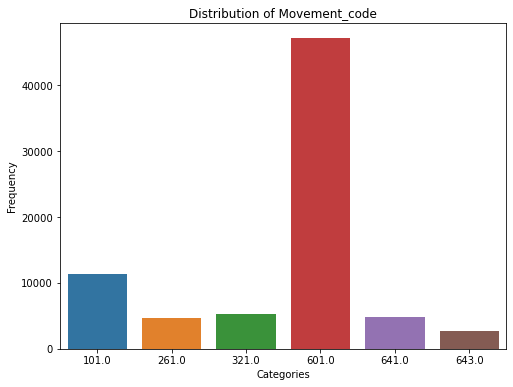

In [20]:
print(mat_mov['Movement_code'].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(x='Movement_code', data=mat_mov)
plt.title('Distribution of Movement_code')
plt.xlabel('Categories')
plt.ylabel('Frequency') 
plt.show()

Consequently we transform Material_type, Movement_code, Movement_ind and Plant_code into categorical:

In [21]:
mat_mov['Material_type'] = mat_mov['Material_type'].astype('category')
mat_mov['Movement_code'] = mat_mov['Movement_code'].astype('category')
mat_mov['Movement_ind'] = mat_mov['Movement_ind'].astype('category')
mat_mov['Plant_code'] = mat_mov['Plant_code'].astype('category')

We have also seen that there are some missing values in the different variables and 17 duplicate rows. We are going to eliminate them all as they are not representative of the total sample.

In [22]:
print("Number of rows before removal:", len(mat_mov))
initial_rows = len(mat_mov)

mat_mov.dropna(inplace=True)
mat_mov.drop_duplicates(inplace=True)

print("Number of rows after removal:", len(mat_mov))
final_rows = len(mat_mov)

percentage_left = final_rows/ initial_rows * 100
print("Percentage of rows left:", percentage_left)


Number of rows before removal: 75988
Number of rows after removal: 75935
Percentage of rows left: 99.93025214507554


We can see that less than 0.1% has been removed which is not representative. As for the bom dataset we are going to check for blank spaces for when we need to join the two tables together:

In [23]:
check_blank_spaces(mat_mov)

No blank spaces found in the 'Material' column.
No blank spaces found in the 'Material_type' column.
No blank spaces found in the 'Batch_number' column.
No blank spaces found in the 'Movement_code' column.
Blank spaces found in the 'Movement_ind' column.
Blank spaces found in the 'Prod_order' column.
No blank spaces found in the 'Date' column.
No blank spaces found in the 'Plant_code' column.


In [24]:
mat_mov['Prod_order'] = mat_mov['Prod_order'].str.strip()

In this case there is no spaces in the key 'Material' column so there would have been no issues.

As an initial analysis we are going to see the relationship between the categorical values through time. To do this a daily and monthly graph are plotted showing the evolution of Movement_ind over time:

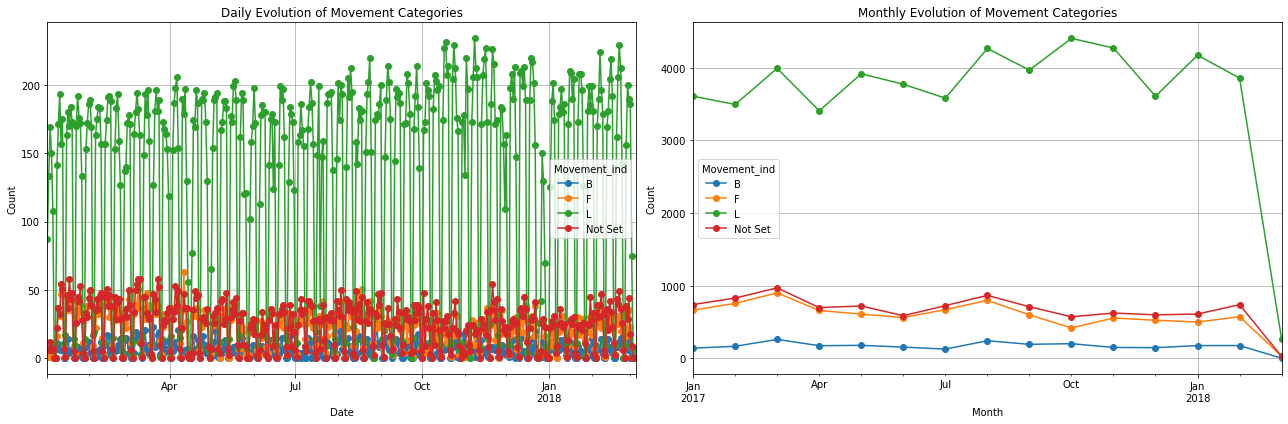

In [25]:

# Count the number of times each movement_ind is per date
movement_ind_counts = mat_mov.groupby([mat_mov['Date'].dt.date, 'Movement_ind']).size().unstack(fill_value=0)

# Change format to date index
movement_ind_counts.index = pd.to_datetime(movement_ind_counts.index)

# Resample to get counts per month
monthly_ind_counts = movement_ind_counts.resample('M').sum()
daily_ind_counts = movement_ind_counts.resample('D').sum()

# Create subplots to get both graphs side by side
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot daily graph on the left
daily_ind_counts.plot(kind='line', marker='o', ax=axs[0])
axs[0].set_title('Daily Evolution of Movement Categories')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Count')
axs[0].legend(title='Movement_ind')
axs[0].grid(True)

# Plot monthly graph on the right
monthly_ind_counts.plot(kind='line', marker='o', ax=axs[1])
axs[1].set_title('Monthly Evolution of Movement Categories')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Count')
axs[1].legend(title='Movement_ind')
axs[1].grid(True)

plt.tight_layout()
plt.show()


As seen in the tables above the evolution of the categories shows that overall L movements are always the most present from January 2017 to March 2019 where there is a generalised decrease as there are only 5 days. We are going to do the same analysis with the Movement_code.

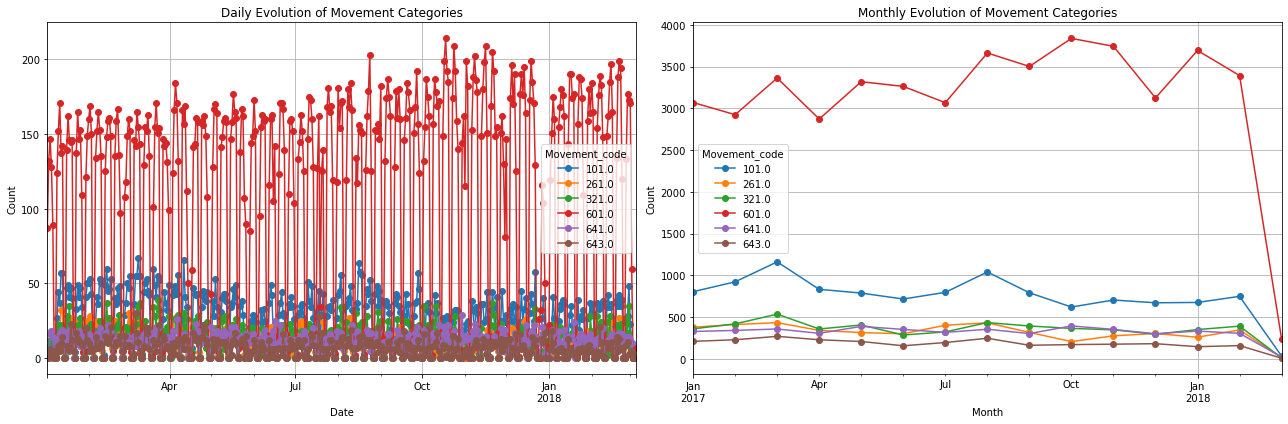

In [26]:

# Count the number of times each movement_code is per date
movement_code_counts = mat_mov.groupby([mat_mov['Date'].dt.date, 'Movement_code']).size().unstack(fill_value=0)

# Change format to date index
movement_code_counts.index = pd.to_datetime(movement_code_counts.index)

# Resample to get counts per month
monthly_code_counts = movement_code_counts.resample('M').sum()
daily_code_counts = movement_code_counts.resample('D').sum()

# Create subplots to get both graphs side by side
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot daily graph on the left
daily_code_counts.plot(kind='line', marker='o', ax=axs[0])
axs[0].set_title('Daily Evolution of Movement Categories')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Count')
axs[0].legend(title='Movement_code')
axs[0].grid(True)

# Plot monthly graph on the right
monthly_code_counts.plot(kind='line', marker='o', ax=axs[1])
axs[1].set_title('Monthly Evolution of Movement Categories')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Count')
axs[1].legend(title='Movement_code')
axs[1].grid(True)

plt.tight_layout()
plt.show()


There graphs for the movement_code are really similar to the ones for the movement indicator and we are going to see how they are related.

In [27]:
movement_table = mat_mov.groupby(['Movement_ind', 'Movement_code']).size().reset_index(name='Count')

# Filter out rows with no observations
movement_table = movement_table[movement_table['Count'] > 0]

print(movement_table)


   Movement_ind Movement_code  Count
0             B         101.0   2492
6             F         101.0   8822
15            L         601.0  47088
16            L         641.0   4760
17            L         643.0   2751
19      Not Set         261.0   4743
20      Not Set         321.0   5279


Based on the guidelines for the assessment and the table above we want to find the lead time between a primary or initial component being received (B-101) until the final product is sold (L-601). To make this easier we are going to combine the movement code and movement ind columns into one. 

In [28]:
mat_mov['Movement'] = mat_mov['Movement_ind'].astype(str) + ' - ' + mat_mov['Movement_code'].astype(str)

mat_mov = mat_mov.sort_values(by=['Batch_number', 'Date'])
mat_mov.head(10)

,Material,Material_type,Batch_number,Movement_code,Movement_ind,Prod_order,Date,Plant_code,Movement
43922,F000122603,FERT,J25565,101.0,B,Not Set,2017-03-03,AW01,B - 101.0
29776,F000098632,FERT,J73337,643.0,L,Not Set,2017-01-13,AI01,L - 643.0
24267,F000099482,FERT,L22373,601.0,L,Not Set,2017-03-08,DB01,L - 601.0
3648,F000024082,FERT,L33597,601.0,L,Not Set,2017-09-12,DF01,L - 601.0
24029,F000095566,FERT,L34058,601.0,L,Not Set,2017-03-08,DB01,L - 601.0
33522,F000101654,FERT,L42061,601.0,L,Not Set,2017-03-08,DB01,L - 601.0
5572,F000022574,FERT,L50547,601.0,L,Not Set,2017-01-04,DK01,L - 601.0
5573,F000022574,FERT,L50547,601.0,L,Not Set,2017-01-05,DK01,L - 601.0
5574,F000022574,FERT,L50547,601.0,L,Not Set,2017-01-06,DK01,L - 601.0
5575,F000022574,FERT,L50547,601.0,L,Not Set,2017-01-10,DK01,L - 601.0


In [29]:
mat_mov[mat_mov['Material'] == 'H000133737']

,Material,Material_type,Batch_number,Movement_code,Movement_ind,Prod_order,Date,Plant_code,Movement
69289,H000133737,HALB,M60865,261.0,Not Set,M77565,2017-09-19,AC01,Not Set - 261.0
68566,H000133737,HALB,N432110,261.0,Not Set,S32154,2017-02-28,AB01,Not Set - 261.0
68567,H000133737,HALB,N432110,261.0,Not Set,S54849,2017-02-28,AB01,Not Set - 261.0
68568,H000133737,HALB,N432110,261.0,Not Set,S659103,2017-02-28,AB01,Not Set - 261.0
68572,H000133737,HALB,N432110,261.0,Not Set,S54855,2017-03-01,AB01,Not Set - 261.0
...,...,...,...,...,...,...,...,...,...
68340,H000133737,HALB,W612110,101.0,F,W612110,2018-02-28,AA01,F - 101.0
68339,H000133737,HALB,W612111,101.0,F,W612111,2018-02-27,AA01,F - 101.0
68341,H000133737,HALB,W612112,101.0,F,W612112,2018-02-28,AA01,F - 101.0
68342,H000133737,HALB,W612112,101.0,F,W612112,2018-03-01,AA01,F - 101.0


## Calculation of  Product Lead times

To calculate the Lead Times of the product we need to know the starting date and the finishing date of each batch of material. Since the movement table seems to be a snapshot of a whole dataset, there can be supply chains which are at a point in the middle. Consequently we have to filter those out. After inspection of the movements in the Excel file supplied and the guidelines provided the movements which set the start and finishing times have been understood:

<img src="SUPPLY_CHAIN2.png" alt="Example Image">

We have classified the materials into three different categories:
- Raw material, which means it is not obtained by any manufacturing process, then the starting point of its lead time is when the product is received (Movement: 101-B) and its finish time is when it is used to produce a new material (Movement: 261-Not Set).
- Intermediate Product is an item produced by other materials which will be used again in the chain of production. Consequently its starting point is in it manufacture (Movement: 101-F) and its finishing point when used to produce a subsequent product (Movement: 261-Not Set). There can be several intermediate products connected.
- Final Product is the item which is produced to be sold. Starting point on its production (Movement: 101-F) and finishing point when it is sold (Movement: 601-L).

With this the lead time of each batch of product will be calculated using differences. As each batch may have different lead times we are going to do an average time per product and then add this averages to obtain the whole supply chain's lead time. In cases where several products produce a new one, the maximum LT is going to be used as the new product will not be manufactured until all the components are ready.

$\ {LT}_{Batch} = {LT}_{Max} - {LT}_{Min} $


Where:

- $\ {LT}_{Max} $ = Lead time per batch 
- $\ {LT}_{Max} $ = Maximum date of a specific movement in a batch
- $\ {LT}_{Min} $ = Minimum date of a specific movement in a batch

All the intermediate movements between the maximum and minimum dates are not going to be used. By calculating the maximum date of the product we consider lead time until the last item of the batch is sold.

Consequently the next step is going to classify all the materials in Raw, Intermediate and Final:

In [30]:
unique_materials = pd.concat([bom['Material'], bom['Component']]).unique()

In [31]:

conditions = [
    np.isin(unique_materials, mat_mov[mat_mov['Material_type']=='HALB']['Material']),  # Check if material is in column A
    np.isin(unique_materials, mat_mov[mat_mov['Material_type']=='FERT']['Material']),  # Check if material is in column B
]

choices = ['Intermediate', 'Final']

# If material is not found in either column A or column B, assign 'RAW'
unique_materials_category = np.where(np.any(conditions, axis=0), np.select(conditions, choices), 'Raw')
df_unique_materials = pd.DataFrame({'Material': unique_materials, 'Category': unique_materials_category})




Now we are going to check if the Materials in our new df_unique_materials table created from bom table are present in the movement table.

In [32]:
present_mov = df_unique_materials['Material'].isin(mat_mov['Material'])

# Convert the boolean array to strings ('Yes' if present, 'No' if not present)
present_mov = np.where(present_mov, 'Yes', 'No')

# Add 'Present_mov' as a new column to df_unique_materials
df_unique_materials['Present_mov'] = present_mov


In [33]:
categories = df_unique_materials.groupby(['Category', 'Present_mov']).size().reset_index(name='Count')

print(categories)

       Category Present_mov  Count
0         Final         Yes    431
1  Intermediate         Yes     49
2           Raw          No     20


Here we see that there are no raw materials present in the movement table therefore we only will be able to calculate the lead times from the intermediate products. This means from movement 101-F of the first component to 601-L of the final product. To do this we are going to join the 'Category' column to the movement table to know the starting and finishing dates of each material:

#### Starting dates:


In [34]:
mat_mov2 = mat_mov.merge(df_unique_materials, how='left', on='Material')

In [35]:
# Filter to have only 'F - 101.0' movements 
mat_mov2_start = mat_mov2[(mat_mov2['Movement'] =='F - 101.0')]

# Group the filtered DataFrame by 'Material', 'Batch_number', 'Movement', and 'Category'
# Then, aggregate the 'Date' column to find the minimum date, count of dates for each group
Batch_times_start = mat_mov2_start.groupby(['Material', 'Batch_number', 'Movement', 'Category'])['Date'].agg([
    ('Min_date', 'min'),  # Minimum date
    ('Max_date_start', 'max'),  # Minimum date
    ('Count', 'count')    # Count of dates
]).reset_index() 

Batch_times_start['Diff_start'] = Batch_times_start['Max_date_start'] - Batch_times_start['Min_date'] 

In [36]:
Batch_times_start.head()

,Material,Batch_number,Movement,Category,Min_date,Max_date_start,Count,Diff_start
0,F000011709,S32440,F - 101.0,Final,2017-01-20,2017-01-24,2,4 days
1,F000011709,S68850,F - 101.0,Final,2017-04-03,2017-04-06,2,3 days
2,F000011709,T16697,F - 101.0,Final,2017-06-22,2017-06-28,2,6 days
3,F000011709,T993101,F - 101.0,Final,2017-11-14,2017-11-21,2,7 days
4,F000011709,W29835,F - 101.0,Final,2018-01-30,2018-02-05,2,6 days


#### Ending dates:

In [37]:
# Filter to have only ending phase movements 
mat_mov2_end = mat_mov2[(
        (mat_mov2['Category'] == 'Final') & 
        (mat_mov2['Movement'] == 'L - 601.0'))
     | (
        (mat_mov2['Category'] == 'Intermediate') & 
        (mat_mov2['Movement'] == 'Not Set - 261.0'))]

# Group the filtered DataFrame by 'Material', 'Batch_number', 'Movement', and 'Category'
# Then, aggregate the 'Date' column to find the maximum date, count of dates for each group
Batch_times_end = mat_mov2_end.groupby(['Material', 'Batch_number', 'Movement', 'Category'])['Date'].agg([
    ('Max_date', 'max'),  # Minimum date
    ('Min_date_end', 'min'),  # Minimum date
    ('Count', 'count')    # Count of dates
]).reset_index()

Batch_times_end['Diff_end'] = Batch_times_end['Max_date'] - Batch_times_end['Min_date_end'] 

In [38]:
Batch_times_end.head()

,Material,Batch_number,Movement,Category,Max_date,Min_date_end,Count,Diff_end
0,F000020080,S198111,L - 601.0,Final,2018-03-02,2017-04-03,111,333 days
1,F000020417,S198108,L - 601.0,Final,2018-03-02,2017-04-04,80,332 days
2,F000020625,S54974,L - 601.0,Final,2017-06-23,2017-03-27,3,88 days
3,F000020979,M53659,L - 601.0,Final,2017-02-16,2017-01-03,27,44 days
4,F000020979,R42368,L - 601.0,Final,2017-07-20,2017-02-16,80,154 days


#### Calculation of Supply Chain Lead Times

We have now the reference dates needed to calculate the lead times per product and for the total supply chains. We only keep the batches that have a starting point and a finishing point. This is done with an inner join.

In [39]:
Batch_times = Batch_times_start.merge(Batch_times_end, how='inner', on=['Material','Batch_number','Category'])
Batch_times['LT_Batch'] = Batch_times['Max_date'] - Batch_times['Min_date']

In [40]:
Batch_times.head()

,Material,Batch_number,Movement_x,Category,Min_date,Max_date_start,Count_x,Diff_start,Movement_y,Max_date,Min_date_end,Count_y,Diff_end,LT_Batch
0,F000020080,S198111,F - 101.0,Final,2017-01-10,2017-01-10,1,0 days,L - 601.0,2018-03-02,2017-04-03,111,333 days,416 days
1,F000020417,S198108,F - 101.0,Final,2017-01-10,2017-01-13,2,3 days,L - 601.0,2018-03-02,2017-04-04,80,332 days,416 days
2,F000020625,S54974,F - 101.0,Final,2017-03-02,2017-03-03,2,1 days,L - 601.0,2017-06-23,2017-03-27,3,88 days,113 days
3,F000020979,T16636,F - 101.0,Final,2017-06-22,2017-06-28,2,6 days,L - 601.0,2017-09-21,2017-07-20,36,63 days,91 days
4,F000020979,T48273,F - 101.0,Final,2017-08-21,2017-08-25,2,4 days,L - 601.0,2018-03-02,2017-09-21,80,162 days,193 days


In [41]:
Product_times = Batch_times.groupby(['Material'])['LT_Batch'].agg([('LT_Prod', 'mean')]).reset_index()

In [42]:
Product_times.head()

,Material,LT_Prod
0,F000020080,416 days 00:00:00
1,F000020417,416 days 00:00:00
2,F000020625,113 days 00:00:00
3,F000020979,142 days 00:00:00
4,F000021005,96 days 08:00:00


In [43]:
Total_0 = chain3.merge(Product_times, how='left', on='Material', suffixes=('', '_0'))
Total_1 = Total_0.merge(Product_times, how='left', left_on='Component', right_on='Material', suffixes=('', '_1'))
Total_2 = Total_1.merge(Product_times, how='left', left_on='Component_2', right_on='Material', suffixes=('', '_2'))
Total_3 = Total_2.merge(Product_times, how='left', left_on='Component_3', right_on='Material', suffixes=('', '_3'))
Total_4 = Total_3.merge(Product_times, how='left', left_on='Component_4', right_on='Material', suffixes=('', '_4'))


Total_4.drop(['Material_1','Material_2','Material_3','Material_4'], axis=1, inplace=True)

In [44]:
Total_4.head(5)

,Plant,Material,Component,Plant_2,Component_2,Plant_3,Component_3,Plant_4,Component_4,Comp_category,LT_Prod,LT_Prod_1,LT_Prod_2,LT_Prod_3,LT_Prod_4
0,BA01,F000134591,H000132846,AB01,H000940217,AB01,H000133737,AA01,H2SD9623,4,126 days 10:17:08.571428572,NaT,67 days 01:17:08.571428571,170 days 19:49:33.913043478,NaT
1,BA01,F000134591,H000132846,AB01,H000940217,AB01,H000133737,AA01,H4LQ8330,4,126 days 10:17:08.571428572,NaT,67 days 01:17:08.571428571,170 days 19:49:33.913043478,NaT
2,BA01,F000134591,H000132846,AB01,H000940217,AB01,H000133737,AA01,H5LQ6450,4,126 days 10:17:08.571428572,NaT,67 days 01:17:08.571428571,170 days 19:49:33.913043478,NaT
3,BA01,F000137515,H000137029,NaN,NaN,NaN,NaN,NaN,NaN,1,221 days 12:00:00,NaT,NaT,NaT,NaT
4,AB01,F000013151,H000953195,AB01,H000133737,AA01,H2SD9623,NaN,NaN,3,NaT,64 days 14:46:09.230769231,170 days 19:49:33.913043478,NaT,NaT


As it can bee seen in the table above, there are some products with no lead times informed. This is because the batches in the movement tables do not have the complete process of production of the batch so no lead time can be calculated. Furthermore, the raw materials in each case which are the first component of the chain are not present in the movement dataset son the total lead times will be calculated without them.

In [45]:
Total_4['Total_LT'] = np.where(Total_4['Comp_category'] == '4',
                               Total_4['LT_Prod'] + Total_4['LT_Prod_1'] + Total_4['LT_Prod_2'] + Total_4['LT_Prod_3'],
                               np.where(Total_4['Comp_category'] == '3',
                                        Total_4['LT_Prod'] + Total_4['LT_Prod_1'] + Total_4['LT_Prod_2'],
                                        np.where(Total_4['Comp_category'] == '2',
                                                 Total_4['LT_Prod'] + Total_4['LT_Prod_1'],
                                                 Total_4['LT_Prod']
                                                )
                                       )
                              )


Total_4.head(5)


,Plant,Material,Component,Plant_2,Component_2,Plant_3,Component_3,Plant_4,Component_4,Comp_category,LT_Prod,LT_Prod_1,LT_Prod_2,LT_Prod_3,LT_Prod_4,Total_LT
0,BA01,F000134591,H000132846,AB01,H000940217,AB01,H000133737,AA01,H2SD9623,4,126 days 10:17:08.571428572,NaT,67 days 01:17:08.571428571,170 days 19:49:33.913043478,NaT,NaT
1,BA01,F000134591,H000132846,AB01,H000940217,AB01,H000133737,AA01,H4LQ8330,4,126 days 10:17:08.571428572,NaT,67 days 01:17:08.571428571,170 days 19:49:33.913043478,NaT,NaT
2,BA01,F000134591,H000132846,AB01,H000940217,AB01,H000133737,AA01,H5LQ6450,4,126 days 10:17:08.571428572,NaT,67 days 01:17:08.571428571,170 days 19:49:33.913043478,NaT,NaT
3,BA01,F000137515,H000137029,NaN,NaN,NaN,NaN,NaN,NaN,1,221 days 12:00:00,NaT,NaT,NaT,NaT,221 days 12:00:00
4,AB01,F000013151,H000953195,AB01,H000133737,AA01,H2SD9623,NaN,NaN,3,NaT,64 days 14:46:09.230769231,170 days 19:49:33.913043478,NaT,NaT,NaT


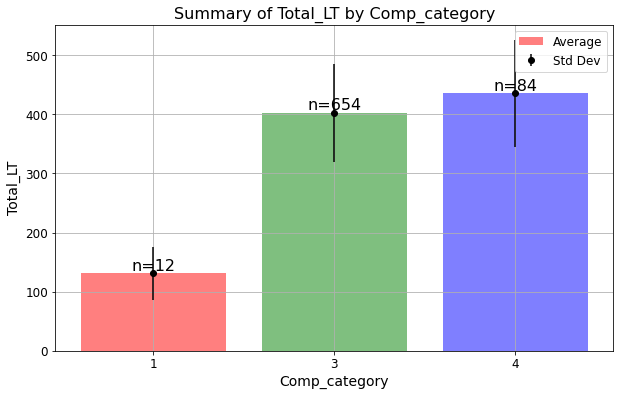

In [46]:

Total_4['Total_LT_days'] = Total_4['Total_LT'].dt.days

# Group by 'Comp_category' and calculate statistics
summary = Total_4.groupby(['Comp_category']).agg(
    Average_LT=('Total_LT_days', 'mean'),
    Min_LT=('Total_LT_days', 'min'),
    Max_LT=('Total_LT_days', 'max'),
    Std_LT=('Total_LT_days', 'std'),
    Count=('Total_LT_days', 'count')
).reset_index()

colors = ['red', 'green', 'blue']

# Create a barplot
plt.figure(figsize=(10, 6))
bars = plt.bar(summary['Comp_category'], summary['Average_LT'], color=colors, alpha=0.5, label='Average')
plt.errorbar(summary['Comp_category'], summary['Average_LT'], yerr=summary['Std_LT'], fmt='o', color='black', label='Std Dev')

for bar, count in zip(bars, summary['Count']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'n={count}', ha='center', va='bottom', fontsize=16)

plt.title('Summary of Total_LT by Comp_category', fontsize=16)
plt.xlabel('Comp_category', fontsize=14)
plt.ylabel('Total_LT', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()




In [47]:
summary.head()

,Comp_category,Average_LT,Min_LT,Max_LT,Std_LT,Count
0,1,131.333333,75.0,221.0,44.685433,12
1,3,402.211009,220.0,689.0,83.422933,654
2,4,435.178571,310.0,620.0,89.982751,84


We have calculated final lead times for the different categories considering the dependancies of the product. As seen on the graph and table for those products where only one component is needed, the average lead time is much smaller than for those which need 3 or 4 different transformations. To finalize the analysis we study the duration of the starting and ending movements:

In [48]:
Product_times = Batch_times_end.groupby(['Movement'])['Diff_end'].agg([('End', 'mean')]).reset_index()
Product_times.head()

,Movement,End
0,L - 601.0,66 days 17:58:05.038438794
1,Not Set - 261.0,12 days 03:13:14.805194805


In [49]:
Product_times2 = Batch_times_start.groupby(['Movement'])['Diff_start'].agg([('Start', 'mean')]).reset_index()
Product_times2.head()

,Movement,Start
0,F - 101.0,7 days 13:09:20.513643659


In order to reduce the average lead time of the products, a detailed study could be performed on the sale movement as it is the longest and the most present as seen in the graphs of the counts of movements with time. This could reduce both lead times and stock costs.